**Assignments 2&3 - Deep Learning**

Antonakaki Eleni

Lt1200002

Master Language Technology

CONVOLUTIONAL NEURAL NETWORK MODEL

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from tqdm import tqdm
import spacy
import string
import re
import nltk
import torch
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from torch import optim
import torchtext 
import pickle
import random
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
def set_seed(seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(25)

In [3]:
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
CUDA_LAUNCH_BLOCKING = "1"
cuda = True
os.system('CUDA_LAUNCH_BLOCKING=1')
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")

torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


In [5]:
#loading the data
reviews = pd.read_csv("IMDB_reviews.csv")
print(reviews.shape)

reviews.head()

(50000, 2)


,review,sentiment
0,"Someone(or, something thing..)is leaving punct...",positive
1,Beginning with the poster (featuring only Morg...,negative
2,This movie is one of the most awful movies eve...,negative
3,Generally political messages are done on telev...,negative
4,I'm surprised at the comments from posters sta...,positive


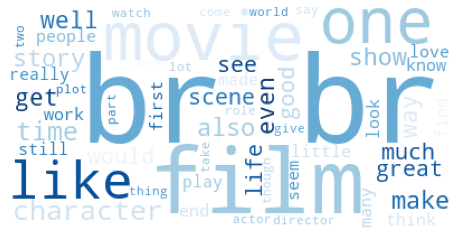

In [6]:
from wordcloud import WordCloud

def plot_wordcloud(review, cmap):
    fig, ax = plt.subplots(figsize=(8, 6))
    wc = WordCloud(max_words = 1000, background_color ='white', stopwords = stopwords, 
                   min_font_size = 10, colormap=cmap)
    wc = wc.generate(review)
    plt.axis('off')
    plt.imshow(wc)

# word cloud on positve reviews
pos_rev = ' '.join(reviews[reviews['sentiment']=='positive']['review'].to_list()[:10000])
plot_wordcloud(pos_rev, 'Blues')

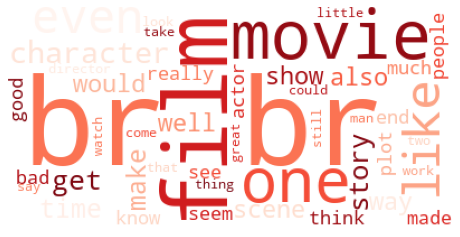

In [7]:
# word cloud on negative reviews
neg_rev = ' '.join(reviews[reviews['sentiment']=='negative']['review'].to_list()[:10000])
plot_wordcloud(neg_rev, 'Reds')

In [8]:
#Convert categorical data into numerical 
# 1 for "positive", 0 for "negative"
le = LabelEncoder()
label = le.fit_transform(reviews['sentiment'])
reviews['label'] = label

reviews = reviews.drop('sentiment', 1)
reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


,review,label
0,"Someone(or, something thing..)is leaving punct...",1
1,Beginning with the poster (featuring only Morg...,0
2,This movie is one of the most awful movies eve...,0
3,Generally political messages are done on telev...,0
4,I'm surprised at the comments from posters sta...,1


label
0    25000
1    25000
dtype: int64


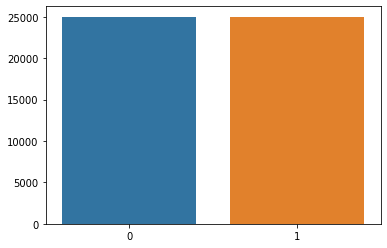

In [9]:
#analysing labels
print(reviews.groupby(['label']).size())

dd = pd.Series(reviews['label']).value_counts()
sns.barplot(x=np.array(['0','1']),y= dd.values)
plt.show()

**3. Processing**

1. remove punctuation
2. remove emoticons
3. lowercasing
4. remove stopwords
5. Porter Stemmer

In [10]:
#process data
reviews['review'].fillna('')

def preprocess_text(text):
                
        TAG_RE = re.compile(r'<[^>]+>_-@')
        no_tags = TAG_RE.sub('',text) 
        text = re.sub('<[^>]*>_@-', '', no_tags)        
        text = re.sub('_','',text) 
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
        text = re.sub('[\W]+', ' ', text.lower()) + " ".join(emoticons).replace('-', '')
        text = re.sub(r'\d+', '', text)

        return text

def remove_stopwords(text):

    text = nltk.word_tokenize(text)
    text = [w for w in text if not w in stopwords]
    text= ' '.join(text)
      
    return text


stemming = PorterStemmer()
def porterstemmer(text):
    return " ".join([stemming.stem(w) for w in text])


In [11]:
#process on data
reviews['review']=reviews['review'].apply(preprocess_text)
reviews['review']=reviews['review'].apply(remove_stopwords)
#reviews['review']= reviews['review'].apply(porterstemmer).copy()

reviews.head()

,review,label
0,someone something thing leaving puncture marks...,1
1,beginning poster featuring morgan freeman kevi...,0
2,movie one awful movies ever made jon bon jovi ...,0
3,generally political messages done television b...,0
4,surprised comments posters stating jane powell...,1


In [12]:
X = reviews['review']
Y = reviews['label']

# Split dataset to train and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state = 1)

# Split train dataset to train and validation set.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state = 1)

print("X_train's shape:", X_train.shape)
print("Y_train's shape:", Y_train.shape)
print("X_val's shape:", X_val.shape)
print("Y_val's shape:", Y_val.shape)
print("X_test's shape:", X_test.shape)
print("Y_test's shape:", Y_test.shape)

X_train's shape: (40500,)
Y_train's shape: (40500,)
X_val's shape: (4500,)
Y_val's shape: (4500,)
X_test's shape: (5000,)
Y_test's shape: (5000,)


In [13]:
#concatenate reviews and labels into a dataframe
df_train = pd.concat([X_train, Y_train], axis=1)
print(df_train.shape)

df_test = pd.concat([X_test, Y_test], axis=1)
print(df_test.shape)

df_valid = pd.concat([X_val, Y_val], axis=1)
print(df_valid.shape)

#save dataframes as ".csv" files
#os.mkdir('dataset')
df_train.to_csv("./dataset/train.csv", index=False)
df_test.to_csv("./dataset/test.csv", index=False)
df_valid.to_csv("./dataset/valid.csv", index=False)

df_train.head()

(40500, 2)
(5000, 2)
(4500, 2)


,review,label
28031,movie amazing never laugh harder target think ...,1
20911,excellent little known movie tom selleck outst...,1
23209,child eighties like probably remember disney m...,1
47822,great addition anyone collection br br monkeys...,1
41184,movies oscar worthy let face sometimes types m...,1


**Use torchtext library for dataset and build vocab**

> *Field* for preprocessing

> *TabularDataset* for loading the train,validation and test data (csv file)

> *BucketIterator* for batching and padding

In [14]:
#calculate mean and maximum sequence length of train dataset

reviews_list=[]
for x in df_train['review']:
  reviews_list.append(x)

print(np.max([len(x) for x in reviews_list]))
print(np.mean([len(x) for x in reviews_list]))
#print(len(reviews_list[1]))

9222
828.2459259259259


In [15]:
TEXT = torchtext.legacy.data.Field(dtype=torch.long,sequential=True, tokenize="spacy",batch_first=True)
#Sequential= whether the datatype represents sequential data.
#Batch_first=  Whether to produce tensors with the batch dimension first.
LABEL = torchtext.legacy.data.LabelField(dtype=torch.long, sequential=False)

In [16]:
train_data, valid_data, test_data = torchtext.legacy.data.TabularDataset.splits( 
    path="/content/dataset/", 
    train="train.csv", 
    validation="valid.csv",
    test= "test.csv", 
    format="csv", 
    skip_header=True, 
    fields=[('text', TEXT), ('label', LABEL)])

print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(valid_data)}')
print(f'Number of test samples: {len(test_data)}')

Number of training samples: 40500
Number of validation samples: 4500
Number of test samples: 5000


In [17]:
#build vocabulary
TEXT.build_vocab(train_data, vectors='glove.6B.100d', min_freq=3, unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocab: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocab: {len(LABEL.vocab)}")

Unique tokens in TEXT vocab: 46262
Unique tokens in LABEL vocab: 2


In [18]:
BATCH_SIZE = 64

#Defines an iterator that batches examples of similar lengths together.
# Sort key= sorting examples in order to batch together examples with similar lengths and minimize padding. 
train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
      sort_key=lambda x: len(x.text),
      batch_size=BATCH_SIZE,
      shuffle=True,
      device=device)

# Print number of batches per dataset.
print('Created `train_iterator` with %d batches!'%len(train_iterator))
print('Created `valid_iterator` with %d batches!'%len(valid_iterator))
print('Created `test_iterator` with %d batches!'%len(test_iterator))

Created `train_iterator` with 633 batches!
Created `valid_iterator` with 71 batches!
Created `test_iterator` with 79 batches!


In [19]:
word_embeddings = TEXT.vocab.vectors
#print(word_embeddings[2])
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1})


2. THE CNN MODEL

In [20]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pretrained_embedding, freeze_embedding):
        
        super().__init__()
                
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embedding_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                        
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
            
        return self.fc(cat)

In [21]:
#hyperparameters
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 10
FILTER_SIZE = [2,3,4]
OUTPUT_DIM = 1
DROPOUT =0.5
learning_rate =0.001

#define model
#net = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZE, OUTPUT_DIM, DROPOUT, pretrained_embedding= None, freeze_embedding=True)
net = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZE, OUTPUT_DIM, DROPOUT, pretrained_embedding= word_embeddings, freeze_embedding=False)

# Initialization of optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr =learning_rate)
criterion = nn.BCEWithLogitsLoss()
net.to(device)

CNN(
  (embedding): Embedding(46262, 100)
  (convs): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 10, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 10, kernel_size=(4, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [22]:
def binary_accuracy(preds, y):

    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [23]:
def model_train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        #predictions = torch.round(torch.sigmoid(predictions))
        
        #print(predictions)
        loss = criterion(predictions, batch.label.float())
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def model_eval(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    predictions_list = []
    labels = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            predictions_list.append(predictions)
            
            loss = criterion(predictions, batch.label.float())
            
            acc = binary_accuracy(predictions, batch.label)
            labels.append(batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
       
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Train and evaluate model**

In [25]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
num_epochs= 5
epoch=0

for epoch in range(num_epochs):
  
  train_loss, train_acc = model_train(net, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = model_eval(net, valid_iterator, criterion)
  epoch +=1
  
  torch.save(net.state_dict(), 'tut4-model.pt')
  
  train_losses.append(train_loss)
  val_losses.append(valid_loss)
  train_accs.append(train_acc)
  val_accs.append(valid_acc)
  
  print(f'EPOCH {epoch}: Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | Val. Loss: {valid_loss:.3f} | Validation Acc: {valid_acc:.3f} ')

EPOCH 1: Train Loss: 0.518 | Train Acc: 0.739 | Val. Loss: 0.371 | Validation Acc: 0.844 
EPOCH 2: Train Loss: 0.371 | Train Acc: 0.844 | Val. Loss: 0.323 | Validation Acc: 0.869 
EPOCH 3: Train Loss: 0.301 | Train Acc: 0.879 | Val. Loss: 0.296 | Validation Acc: 0.876 
EPOCH 4: Train Loss: 0.242 | Train Acc: 0.909 | Val. Loss: 0.298 | Validation Acc: 0.877 
EPOCH 5: Train Loss: 0.196 | Train Acc: 0.929 | Val. Loss: 0.309 | Validation Acc: 0.879 


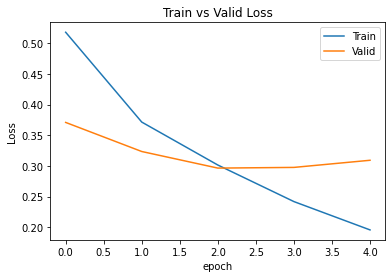

In [26]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

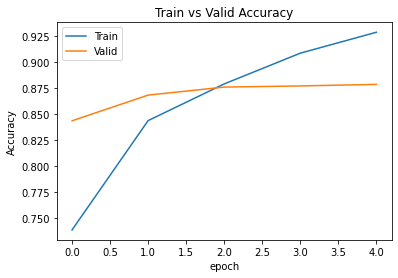

In [27]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

**Predictions on test set**

1. confusion matrix
2. classification report

In [28]:
def prediction(model, iterator):
    epoch_loss = 0
    epoch_acc = 0
    predictions_list = []
    labels = []
 
    model.eval()  
    with torch.no_grad():
        for batch in iterator:
              predictions = model(batch.text).squeeze(1)
              #print(predictions)
                            
              acc = binary_accuracy(predictions, batch.label)
              predictions = torch.round(torch.sigmoid(predictions))
              predictions_list.append(predictions)
              labels.append(batch.label)

              epoch_acc += acc.item()   
    
    return epoch_acc / len(iterator), predictions_list, labels

In [29]:
acc, predictions_list, labels = prediction(net, test_iterator)
print("Acc for test set:", acc*100,"%")

Acc for test set: 86.51107594936708 %


In [30]:
#plot classification report 
actual=[]
preds = []
for i in predictions_list:
   for m in i:
      preds.append(m.float().cpu().detach().numpy())
for i in labels:
  for m in i:
    actual.append(m.float().cpu().detach().numpy())

class_report = classification_report(actual, preds)
print(class_report)


              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      2478
         1.0       0.86      0.88      0.87      2522

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



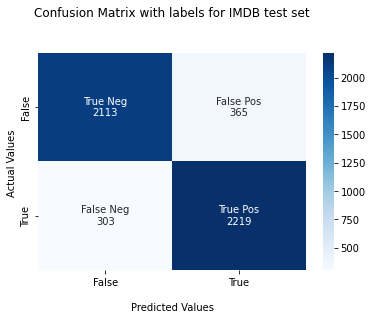

In [31]:
#plot confusion matrix

conf_matrix = confusion_matrix(actual, preds)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]


labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with labels for IMDB test set\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()